In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the ablation dataset
data_path = os.path.join("..", "data", "ablation_studies", "gamma", "all_results.csv")
data = pd.read_csv(data_path)

# Prepare the data
for column in data.columns:
    is_float = False
    try:
        float(column)
        is_float = True
    except:
        pass
    if is_float:
        new_column = f"{float(column):.3f}"
        data.rename(columns={column: new_column}, inplace=True)

Let's start by plotting the evolution of the mean regret vs gamma for the Branin function.


<Figure size 1500x4500 with 0 Axes>

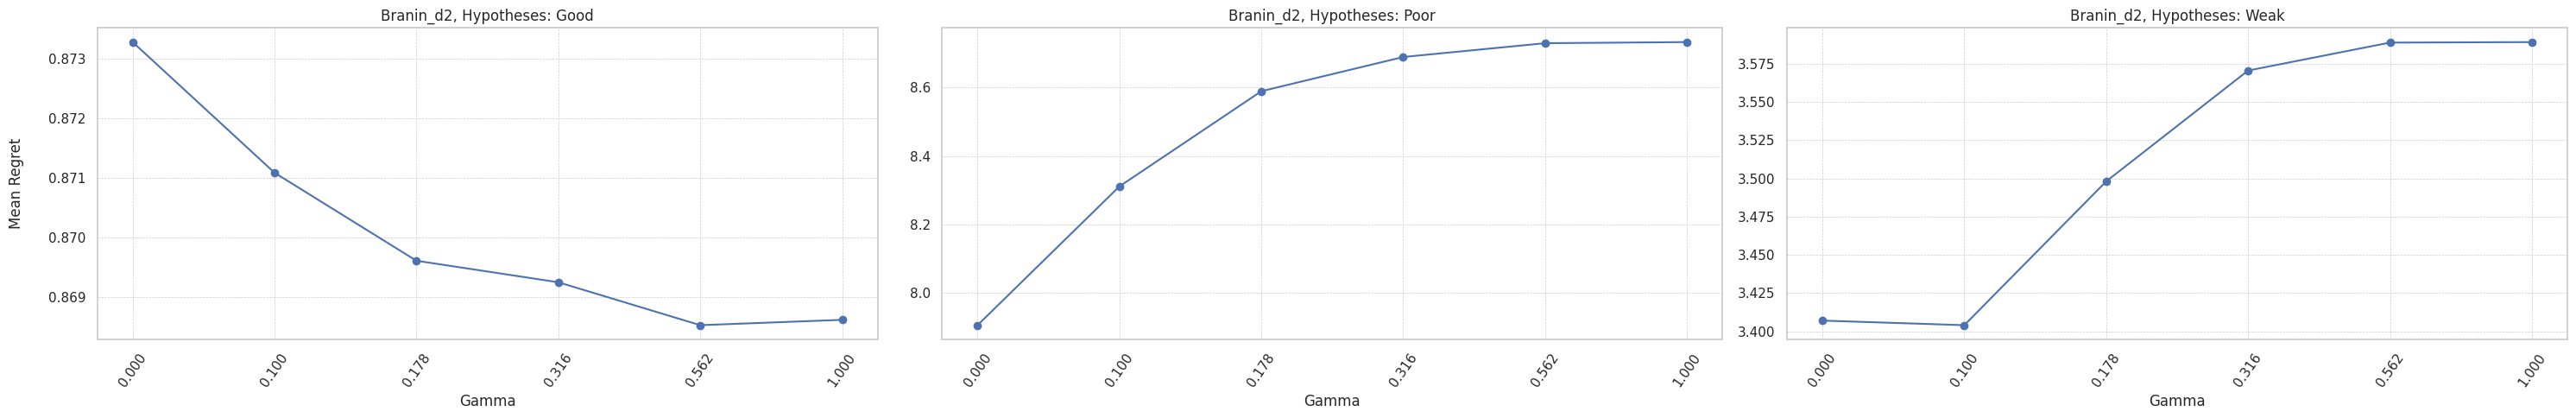

In [2]:
this_data = data.copy()

# Dropping the 'Unnamed: 0' column if it exists
if "Unnamed: 0" in data.columns:
    this_data.drop(columns=["Unnamed: 0"], inplace=True)

# Grouping the data by 'Function' and 'Hypotheses'
grouped_data = this_data.groupby(["Function", "Hypotheses"])

# Calculating the mean for each group
mean_performance = grouped_data.mean().reset_index()

# Setting up the visualization
sns.set(style="whitegrid")
num_plots = len(mean_performance["Function"].unique()) * len(
    mean_performance["Hypotheses"].unique()
)
plt.figure(figsize=(15, 5 * num_plots))

plot_num = 1

for function in mean_performance["Function"].unique():
    if "Branin" not in function:
        continue
    plt.figure(figsize=(30, 5))
    plot_num = 1
    for hypothesis in mean_performance["Hypotheses"].unique():
        subset = mean_performance[
            (mean_performance["Function"] == function)
            & (mean_performance["Hypotheses"] == hypothesis)
        ]
        if not subset.empty:
            plt.subplot(
                1, len(mean_performance["Hypotheses"].unique()), plot_num)
            plt.title(f"{function}, Hypotheses: {hypothesis}")
            values = subset.values[:, 2:].flatten()
            plt.plot(subset.columns[2:], values, label=subset["Function"])
            # Add scatter dots to the plot
            plt.scatter(subset.columns[2:], values, marker="o")
            plt.xticks(rotation=55)
            plt.xlabel("Gamma")
            if plot_num == 1:
                # Add labelpad to adjust the distance of the label from the y-axis
                plt.ylabel("Mean Regret", labelpad=20)
            # Set grid lines behind the lines
            plt.grid(True, linestyle="--", linewidth=0.5, zorder=0)
            plt.tight_layout()
            plot_num += 1

    plt.show()

Let's see what the trend is when we combine all functions.


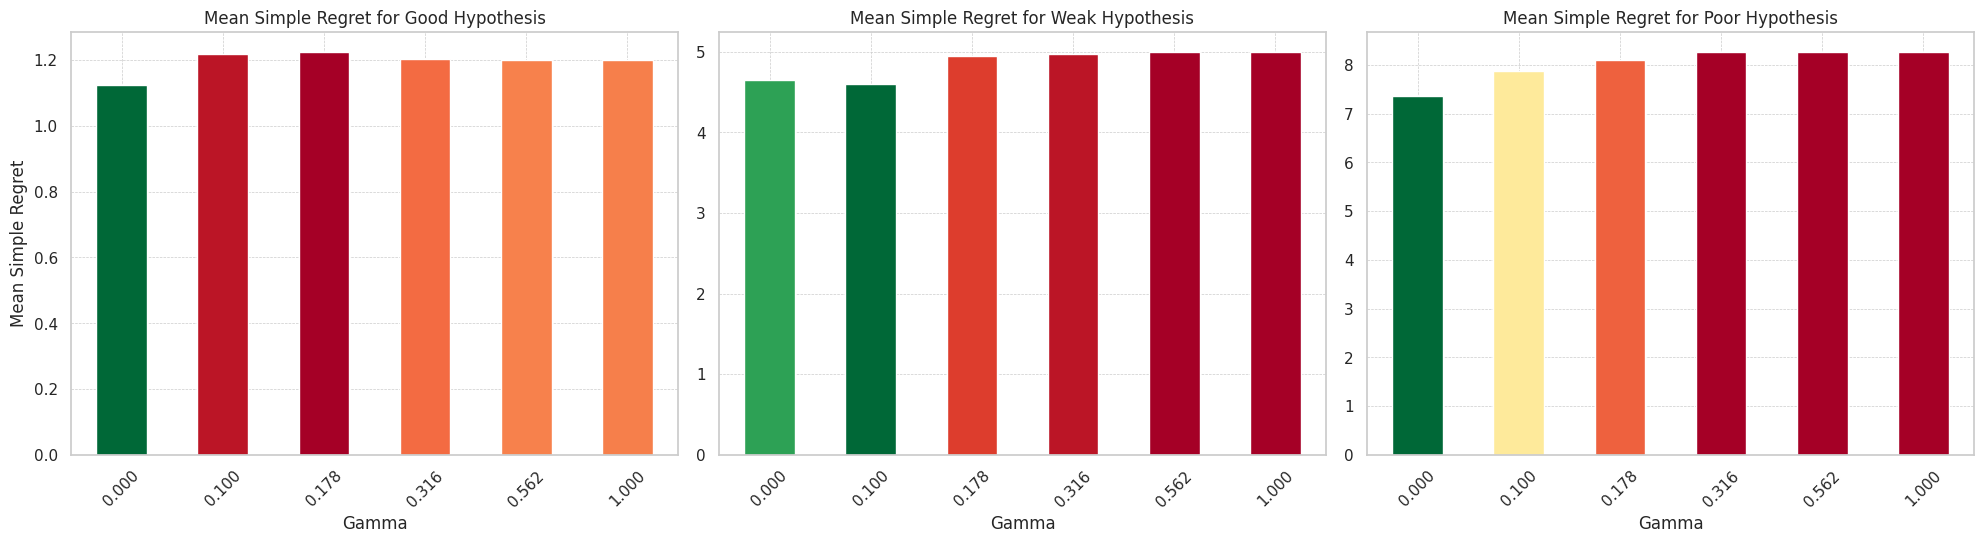

In [3]:
import warnings

# Ignore warnings of ipykernel about matplotlib params that will be deprecated in the future
warnings.filterwarnings("ignore")

this_data = data.copy()

# Define the hypothesis mixtures
hypotheses = ["Good", "Weak", "Poor"]

# Set up the plot
plt.figure(figsize=(20, 10))
plot_number = 1

for hypothesis in hypotheses:
    # Filter data for the current hypothesis
    hypothesis_data = this_data[this_data["Hypotheses"] == hypothesis].drop(
        columns=["Function", "Hypotheses", "Unnamed: 0"]
    )

    # Calculate mean regret for each parameter combination
    mean_regret = hypothesis_data.mean()

    # Create a subplot for each hypothesis mixture
    ax = plt.subplot(2, 3, plot_number)

    # Plot the bar chart with the color gradient
    color_map = plt.cm.get_cmap("RdYlGn_r")  # Define the color map
    # Calculate the colors based on the mean regret values
    bar_colors = color_map(
        (mean_regret - mean_regret.min()) /
        (mean_regret.max() - mean_regret.min())
    )

    # Plot the bar chart with the colored bars
    mean_regret.plot(kind="bar", ax=ax, color=bar_colors)

    plt.title(f"Mean Simple Regret for {hypothesis} Hypothesis")
    plt.xticks(rotation=45)
    plt.xlabel("Gamma")
    if plot_number == 1:
        plt.ylabel("Mean Simple Regret")
    ax.set_axisbelow(True)  # Set the grid lines behind the bars
    # Add grid to the plot behind the bars
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ax.set_yscale('log')  # Use logarithmic scale for the y-axis
    plot_number += 1

plt.tight_layout()
plt.show()

There seems to be a slight trend:

- Good: performance increases with gamma except for gamma=0
- Weak: performance decreases with gamma
- Poor: performance decreases with gamma


In [4]:
# Load the dataset
this_data = data.copy()

# Dropping the first column which is an index
this_data = this_data.drop(this_data.columns[0], axis=1)

# Calculating the mean regret for each combination of u and l
mean_regrets = this_data.drop(["Function", "Hypotheses"], axis=1).mean()

# Finding the combination with the minimum average regret
optimal_gamma = mean_regrets.idxmin()
min_regret = mean_regrets.min()

optimal_gamma, min_regret

('0.000', 4.382205458163586)

# Looking at the time spent in the lower level


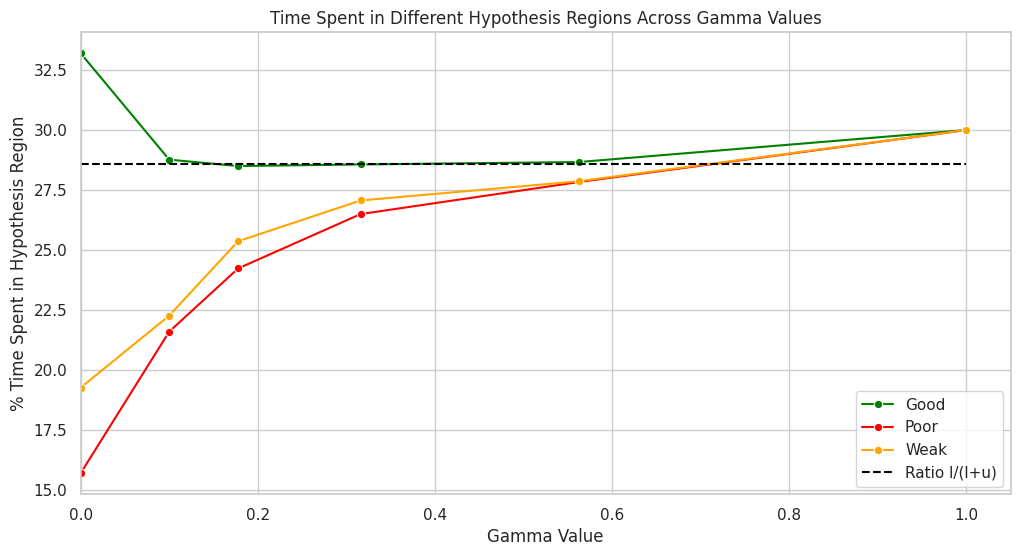

In [5]:
file_path = os.path.join(
    "..", "data", "ablation_studies", "gamma", "time_spent.csv")
time_spent_df = pd.read_csv(file_path)

# Melting the time_spent dataframe for easy plotting
melted_time_spent_df = time_spent_df.melt(
    id_vars="gamma", var_name="Hypothesis", value_name="Time_Spent"
)
# Multiply all values by 100 to turn them into a percentage
melted_time_spent_df["Time_Spent"] = melted_time_spent_df["Time_Spent"].apply(
    lambda x: x * 100
)
# Set the colors to green, red, and orange
colors = ["green", "red", "orange"]

# Plotting time spent in different hypothesis regions for different gamma values
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=melted_time_spent_df,
    x="gamma",
    y="Time_Spent",
    hue="Hypothesis",
    marker="o",
    palette=colors,
)
# Adding the ratio of l/(l+u) as a baseline to the plot.
x = time_spent_df["gamma"]
ratio = 100 * 2 / (2 + 5)
y = [ratio] * len(x)
plt.plot(x, y, color="black", label="Ratio l/(l+u)", linestyle="--")
plt.legend()
# plt.text(0.15, ratio, 'Ration l/(l+u)', ha='right', va='bottom')
plt.title("Time Spent in Different Hypothesis Regions Across Gamma Values")
plt.xlim(left=0)
plt.xlabel("Gamma Value")
plt.ylabel("% Time Spent in Hypothesis Region")
plt.show()